# Importing necessary library packages

In [7]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip uninstall imbalanced-learn scikit-learn

In [ ]:
pip install scikit-learn

In [ ]:
pip install imbalanced-learn

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import SimpleRNN, Dense

# Loading the credit card dataset

In [11]:
spark = SparkSession.builder \
    .appName("Credit Card Data Analysis") \
    .getOrCreate()

print("Loading The Credit Card Data:")

creditcard_data = spark.read.csv('C:/Users/HP/Desktop/Final Project/creditcard.csv', header=True, inferSchema=True)
creditcard_data.show(5)


Loading The Credit Card Data:
+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                

# Data pre-processing

# Display the data information

In [12]:
print("Data Info:")
creditcard_data.printSchema()
num_rows = creditcard_data.count()
num_cols = len(creditcard_data.columns)
print(f"The dataset has {num_rows} rows and {num_cols} columns.")

Data Info:
root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: do

# Checking for missing values

In [13]:
print("Checking For Missing Values:")
missing_values = creditcard_data.select(
    [sum(col(column).isNull().cast("int")).alias(column) for column in creditcard_data.columns]
)

missing_values.show()


Checking For Missing Values:
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



# Summary Statistics

In [14]:
print("Descriptive Analysis:")
creditcard_data.describe().show()

Descriptive Analysis:
+-------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+
|summary|             Time|                  V1|                  V2|                  V3|                  V4|                  V5|                  V6|                  V7|                  V8|                  V9|                 V10|                 V11|                 V12|                 V13|                 V14| 

# Data Visualization

# Log-Transformed Distribution of Transaction Amounts

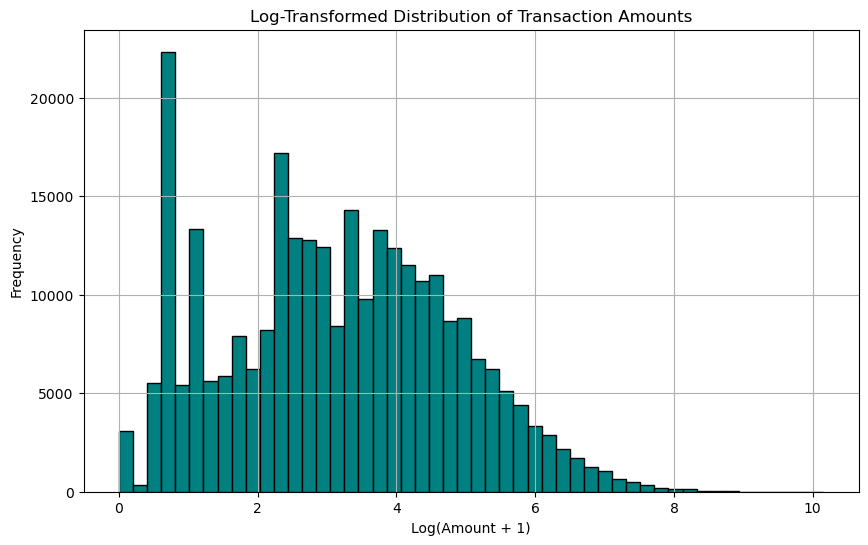

In [15]:
creditcard_data_pandas = creditcard_data.toPandas()
creditcard_data_pandas['Log_Amount'] = np.log1p(creditcard_data_pandas['Amount'])

plt.figure(figsize=(10, 6))
plt.hist(creditcard_data_pandas['Log_Amount'], bins=50, color='teal', edgecolor='black')
plt.title('Log-Transformed Distribution of Transaction Amounts')
plt.xlabel('Log(Amount + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Top 5 Transaction Amounts by Time Segments

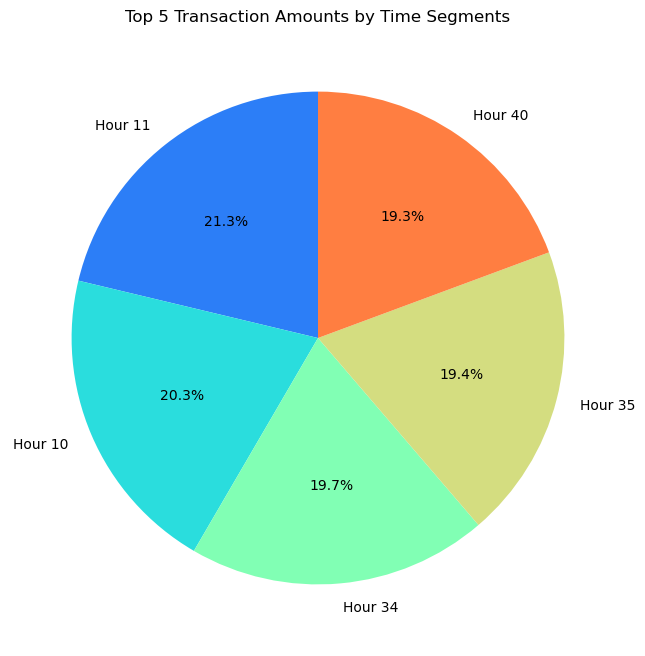

In [16]:
creditcard_data_pandas = creditcard_data.toPandas()
creditcard_data_pandas['Time_Segment'] = (creditcard_data_pandas['Time'] // 3600).astype(int)  
time_segment_amounts = creditcard_data_pandas.groupby('Time_Segment')['Amount'].sum()

top_5_time_segments = time_segment_amounts.nlargest(5)

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_5_time_segments, labels=[f'Hour {i}' for i in top_5_time_segments.index], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('rainbow', len(top_5_time_segments)))
plt.title('Top 5 Transaction Amounts by Time Segments')
plt.show()


# Transaction Amounts by Class

C:\Users\HP\AppData\Local\Temp\ipykernel_20908\3274904241.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='Class', y='Amount', data=creditcard_data_pandas, estimator='mean', ci=None, palette='rainbow')


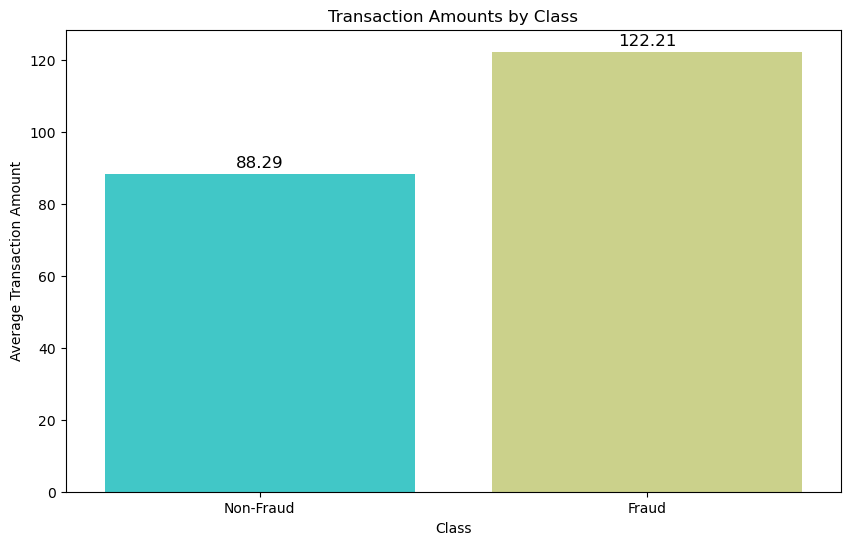

In [17]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Class', y='Amount', data=creditcard_data_pandas, estimator='mean', ci=None, palette='rainbow')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 8), 
                textcoords='offset points')

plt.title('Transaction Amounts by Class')
plt.xlabel('Class')
plt.ylabel('Average Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()


# Transaction Amount by Time Segments

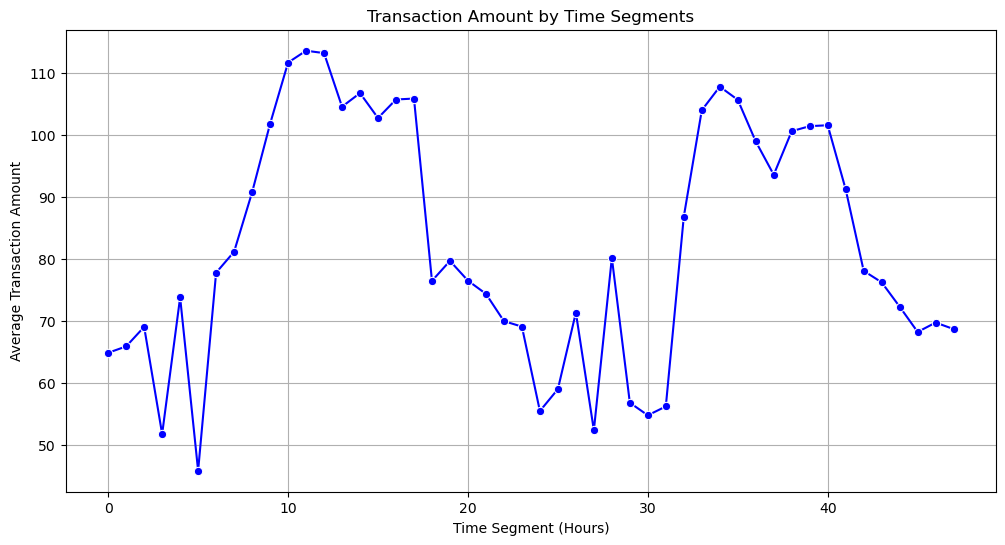

In [18]:
creditcard_data_pandas['Time_Segment'] = (creditcard_data_pandas['Time'] // 3600).astype(int)
time_segment_df = creditcard_data_pandas.groupby('Time_Segment')['Amount'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time_Segment', y='Amount', data=time_segment_df, marker='o', color='blue')
plt.title('Transaction Amount by Time Segments')
plt.xlabel('Time Segment (Hours)')
plt.ylabel('Average Transaction Amount')
plt.grid(True)
plt.show()


# Correlation Matrix

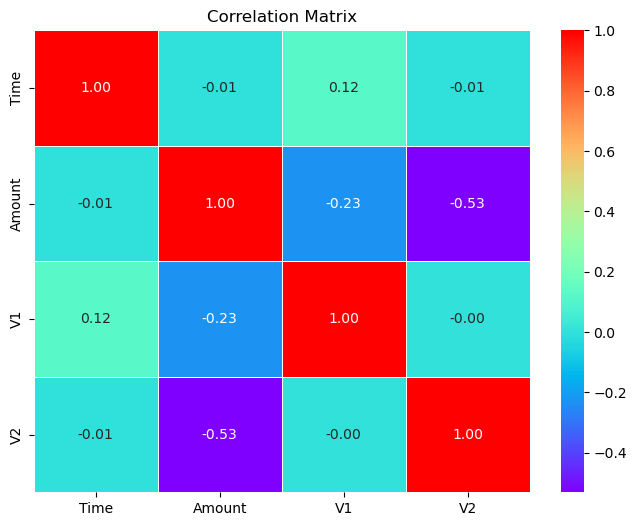

In [19]:
selected_columns = ['Time', 'Amount', 'V1', 'V2']
creditcard_selected = creditcard_data.select(selected_columns)

correlation_matrix = []
for col1 in selected_columns:
    row = []
    for col2 in selected_columns:
        correlation = creditcard_selected.stat.corr(col1, col2)
        row.append(correlation)
    correlation_matrix.append(row)

correlation_df = pd.DataFrame(correlation_matrix, columns=selected_columns, index=selected_columns)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df, annot=True, cmap='rainbow', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# Machine Learning Model

# Resampled Data Shape

In [ ]:
creditcard_pd = creditcard_data.toPandas()

X = creditcard_pd.drop('Class', axis=1)
y = creditcard_pd['Class']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

print("Resampled Data Shape:", resampled_data.shape)


# SMOTE Resampled Data Shape

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

smote_resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

print("SMOTE Resampled Data Shape:", smote_resampled_data.shape)


# ADASYN Resampled Data Shape

In [ ]:
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

adasyn_resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

print("ADASYN Resampled Data Shape:", adasyn_resampled_data.shape)


# Checking the class distribution before and after oversampling

In [ ]:
print("Original Class Distribution:")
print(y.value_counts())

print("\nResampled Class Distribution:")
print(pd.Series(y_resampled).value_counts())


# Model of Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_rf = model.predict(X_test)

print('Classification Report of Random Forest:')
print(classification_report(y_test, y_pred_rf))

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nAccuracy of Random Forest: {accuracy_rf:.4f}")


# Confusion Matrix of Random Forest

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Random Forest")
plt.show()

# Model of Logistic Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

print('Classification Report of Logistic Regression:')
print(classification_report(y_test, y_pred_lr))

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nAccuracy of Logistic Regression: {accuracy_lr:.4f}")


# Confusion Matrix of Logistic Regression

In [ ]:
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

disp_lr = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lr, display_labels=['Class 0', 'Class 1'])
disp_lr.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix of Logistic Regression")
plt.show()


# Model of Decision Tree

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred_dt = model.predict(X_test)

print('Classification Report of Decision Tree:')
print(classification_report(y_test, y_pred_dt))

accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"\nAccuracy of Decision Tree: {accuracy_dt:.4f}")


# Confusion Matrix of Decision Tree

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_dt)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix of Decision Tree")
plt.show()


# Comparison of Machine Learing Model Accuracies

In [ ]:
models = ['Random Forest', 'Logistic Regression', 'Decision Tree']
accuracies = [accuracy_rf, accuracy_lr, accuracy_dt]

plt.bar(models, accuracies, color=['blue', 'green', 'purple'])
plt.ylabel('Accuracy')
plt.title('Comparison of Machine Learing Model Accuracies')
plt.ylim(0, 1.1) 

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.show()


# Deep Learning Model

# Model of Artificial Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

model_ann = Sequential()
model_ann.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))
model_ann.add(Dense(units=32, activation='relu'))
model_ann.add(Dense(units=1, activation='sigmoid'))

model_ann.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model_ann.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred_ann = (model_ann.predict(X_test) > 0.5).astype("int32")

print('Classification Report of Artificial Neural Network:')
print(classification_report(y_test, y_pred_ann))

accuracy_ann = accuracy_score(y_test, y_pred_ann)
print(f"\nAccuracy of Artificial Neural Network: {accuracy_ann:.4f}")


# Confusion Matrix of Artificial Neural Network

In [ ]:
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)

disp_ann = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_ann, display_labels=['Class 0', 'Class 1'])
disp_ann.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix of Artificial Neural Network")
plt.show()


# Model of Recurrent Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dense(units=32, activation='relu'))
model_rnn.add(Dense(units=1, activation='sigmoid'))

model_rnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model_rnn.fit(X_train_rnn, y_train, epochs=10, batch_size=32, validation_data=(X_test_rnn, y_test))

y_pred_rnn = (model_rnn.predict(X_test_rnn) > 0.5).astype("int32")

print('Classification Report of Recurrent Neural Network:')
print(classification_report(y_test, y_pred_rnn))

accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
print(f"\nAccuracy of Recurrent Neural Network: {accuracy_rnn:.4f}")


# Confusion Matrix of Recurrent Neural Network

In [ ]:
conf_matrix_rnn = confusion_matrix(y_test, y_pred_rnn)

disp_rnn = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rnn, display_labels=['Class 0', 'Class 1'])
disp_rnn.plot(cmap=plt.cm.winter)
plt.title("Confusion Matrix of Recurrent Neural Network")
plt.show()


# Comparison of Deep Learning Model Accuracies

In [ ]:
models = ['Artificial Neural Network', 'Recurrent Neural Network']
accuracies = [accuracy_ann, accuracy_rnn]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['orange', 'red'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Deep Learning Model Accuracies')
plt.ylim([0, 1.1])  
plt.show()